In [1]:
import requests, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# Output directory
OUT = Path("output")
OUT.mkdir(exist_ok=True)

# World Bank API
WORLD_BANK_ENDPOINT = "https://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&per_page=1000"
COUNTRIES = {"LTU": "Lithuania", "EUU": "European Union"}
INDICATOR = "SL.UEM.TOTL.ZS"   # Unemployment, total (% of total labor force)
YEAR_START, YEAR_END = 2010, 2024

# Fetch data function
def fetch_series(country_code, indicator):
    url = WORLD_BANK_ENDPOINT.format(country=country_code, indicator=indicator)
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    payload = r.json()
    records = payload[1]
    df = pd.DataFrame.from_records([{
        "country_code": rec.get("countryiso3code"),
        "country": (rec.get("country") or {}).get("value"),
        "date": rec.get("date"),
        "value": rec.get("value")
    } for rec in records])
    df["year"] = pd.to_numeric(df["date"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df[(df["year"] >= YEAR_START) & (df["year"] <= YEAR_END)].copy()
    df.sort_values("year", inplace=True)
    return df[["country_code", "country", "year", "value"]]

# Fetch Lithuania + EU
frames = []
for code, name in COUNTRIES.items():
    d = fetch_series(code, INDICATOR)
    d["country"] = d["country"].fillna(name)
    frames.append(d)

long_df = pd.concat(frames, ignore_index=True)

# Pivot to wide format
wide_df = long_df.pivot_table(index="year", columns="country", values="value").reset_index()

print("=== First 10 rows ===")
print(wide_df.head(10))


=== First 10 rows ===
country  year  European Union  Lithuania
0        2010        9.872721     17.814
1        2011        9.927600     15.390
2        2012       10.875226     13.365
3        2013       11.349908     11.770
4        2014       10.826669     10.698
5        2015       10.018399      9.120
6        2016        9.107661      7.862
7        2017        8.134075      7.073
8        2018        7.255924      6.147
9        2019        6.688576      6.255


In [2]:
def compute_indicators(wide):
    rows = []
    for c in [c for c in wide.columns if c != "year"]:
        s = wide[c]
        rows.append({
            "country": c,
            "avg_percent": s.mean(skipna=True),
            "min_percent": s.min(skipna=True),
            "max_percent": s.max(skipna=True),
            "change_2010_to_2024_pp":
                (wide.loc[wide["year"] == 2024, c].iloc[0] -
                 wide.loc[wide["year"] == 2010, c].iloc[0])
                if (wide["year"] == 2024).any() and (wide["year"] == 2010).any()
                else float("nan")
        })
    return pd.DataFrame(rows)

indicators = compute_indicators(wide_df.copy())
print(indicators)


          country  avg_percent  min_percent  max_percent  \
0  European Union     8.414125      5.91813    11.349908   
1       Lithuania     9.426200      5.95500    17.814000   

   change_2010_to_2024_pp  
0               -3.954591  
1              -10.310000  


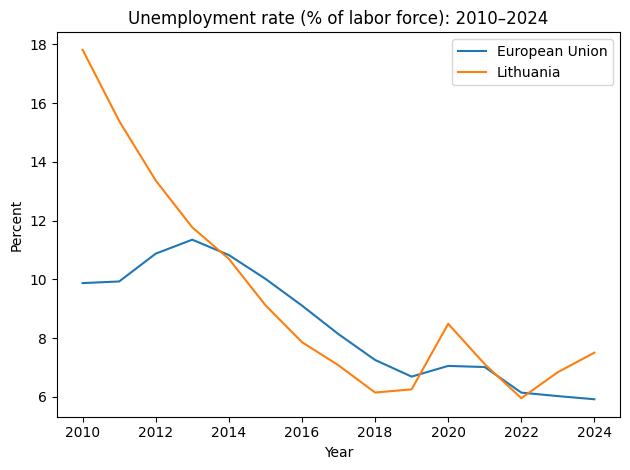

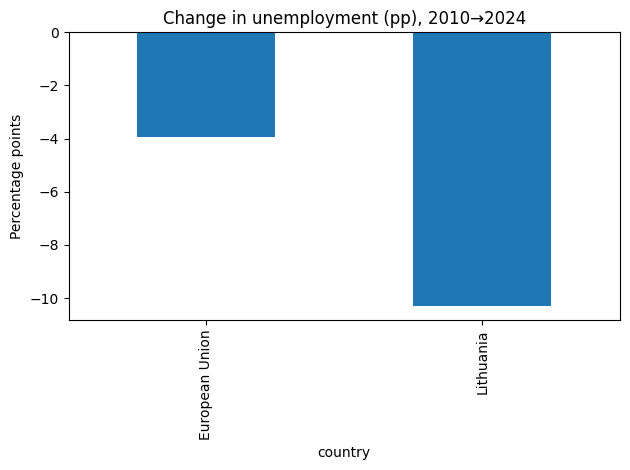

In [3]:
plt.figure()
for col in [c for c in wide_df.columns if c != "year"]:
    plt.plot(wide_df["year"], wide_df[col], label=col)
plt.title("Unemployment rate (% of labor force): 2010–2024")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure()
indicators.set_index("country")["change_2010_to_2024_pp"].plot(kind="bar")
plt.title("Change in unemployment (pp), 2010→2024")
plt.ylabel("Percentage points")
plt.tight_layout()
plt.show()


In [4]:
wide_df.to_csv(OUT / "unemployment_2010_2024.csv", index=False)
indicators.to_csv(OUT / "indicators_2010_2024.csv", index=False)

print("Files saved in:", OUT.absolute())


Files saved in: /content/output
